In [21]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [22]:
def load_config(path):
    with open(path, 'r') as file:
        return json.load(file)

config_path = '../pandas_config.json'
config = load_config(config_path)
parquet_config = config['parquet']

# Setting up the engine as a global constant
ENGINE = parquet_config['engine']
COMPRESSION = parquet_config['compression']
FILE_PATH = "../data/data_parquet"
VISUALIZATION_PATH = "./graphics/"

font_path = '../Helvetica Regular.otf'
bold_font_path = "../Helvetica CE Bold.otf"
normal_font = FontProperties(fname=font_path)
bold_font = FontProperties(fname=bold_font_path)

In [23]:
weights = pd.read_parquet(f"{FILE_PATH}/weights.parquet", engine=ENGINE)
weights_df = weights.map(lambda x: None if isinstance(x, np.ndarray) and x.size == 0 else x)

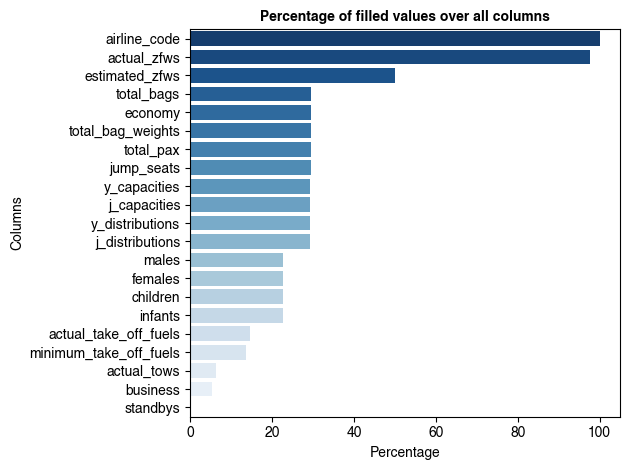

In [24]:
filled_percentages_over_all_flight_ids = weights_df.notnull().mean() * 100
filled_percentages_over_all_flight_ids = filled_percentages_over_all_flight_ids.to_frame().transpose()
filled_percentages_over_all_flight_ids.drop(columns=["flight_id", "flight_number"], inplace=True)
filled_percentages_over_all_flight_ids = filled_percentages_over_all_flight_ids.sort_values(by=0, axis=1, ascending=False)
sns.barplot(data=filled_percentages_over_all_flight_ids, palette="Blues_r", orient="h")
plt.title("Percentage of filled values over all columns", fontproperties=bold_font)
plt.xticks(fontproperties=normal_font);
plt.yticks(fontproperties=normal_font);
plt.xlabel("Percentage", fontproperties=normal_font)
plt.ylabel("Columns", fontproperties=normal_font)
plt.tight_layout()
plt.savefig(f"{VISUALIZATION_PATH}filled_percentages_over_all_columns.svg")

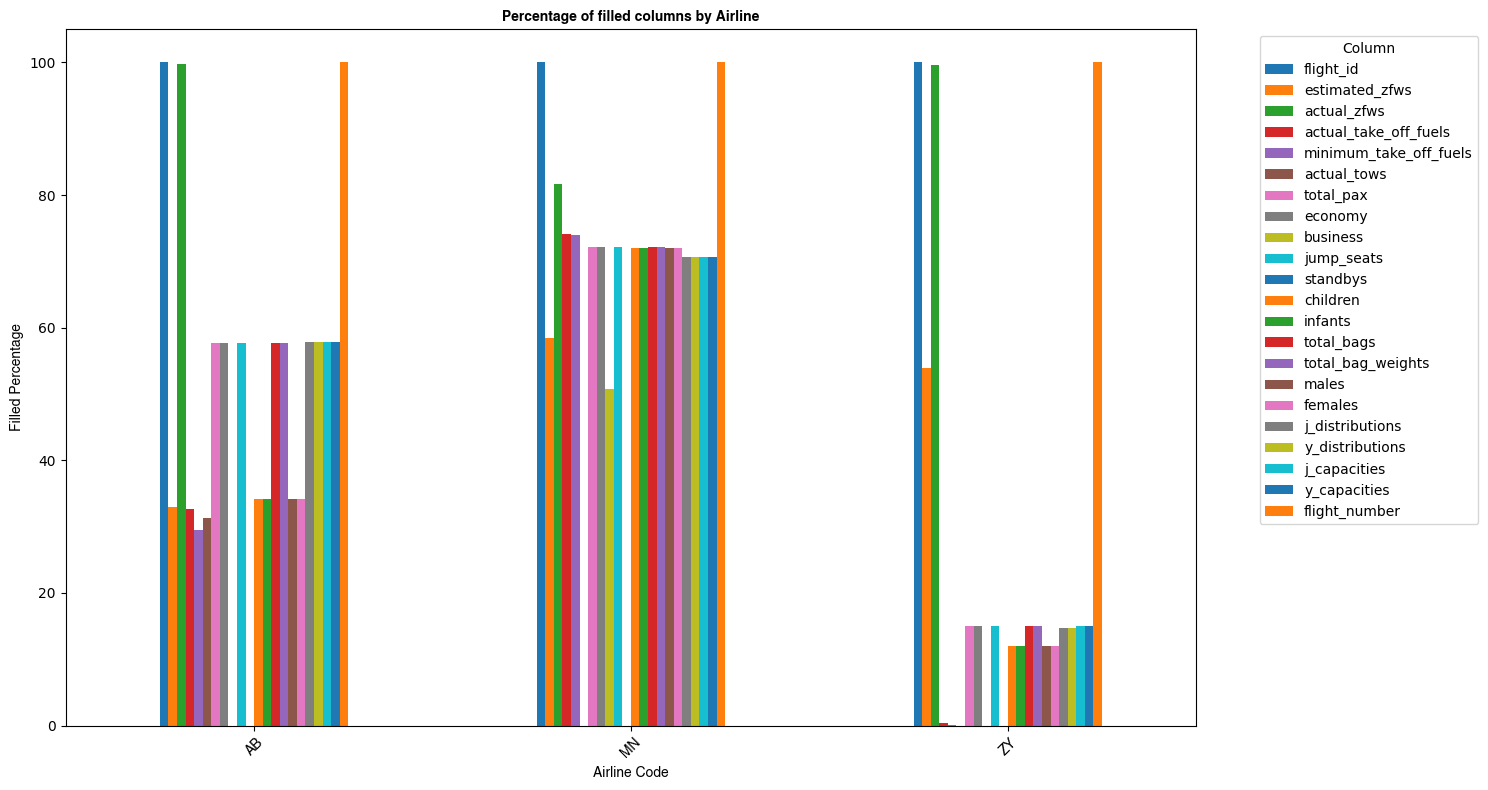

In [25]:
filled_percentage_by_airline = weights_df.drop(columns=["flight_number"]).copy()
filled_percentage_by_airline = weights_df.groupby('airline_code').apply(lambda group: group.notnull().mean() * 100, include_groups=False)
filled_percentage_by_airline.reset_index(inplace=True)
filled_percentage_by_airline.plot(kind='bar', x='airline_code', stacked=False, figsize=(15, 8))
# Add labels and title

plt.title('Percentage of filled columns by Airline', font_properties=bold_font)
plt.xlabel('Airline Code', font_properties=normal_font)
plt.ylabel('Filled Percentage', font_properties=normal_font)
plt.xticks(rotation=45, font_properties=normal_font)
plt.legend(title='Column', bbox_to_anchor=(1.05, 1))

# Save and display the plot
plt.tight_layout()
plt.savefig(f"{VISUALIZATION_PATH}filled_percentage_by_airline.svg")
plt.show()

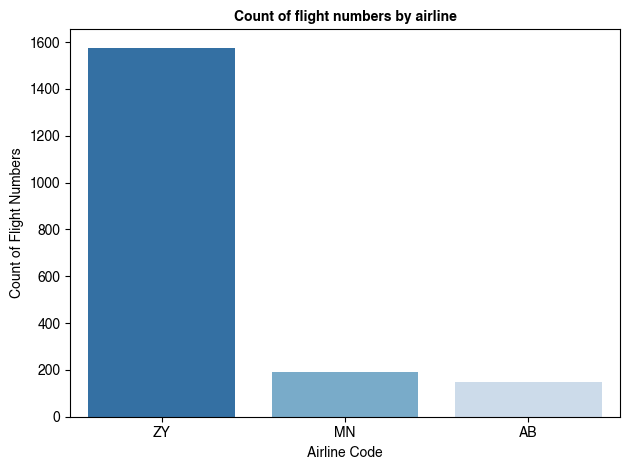

In [26]:
flight_numbers_by_airline = weights_df.groupby('airline_code', group_keys=False).apply(lambda group: group['flight_number'].nunique(), include_groups=False).to_frame().reset_index()
flight_numbers_by_airline.columns = ['airline_code', 'count of flight numbers']
flight_numbers_by_airline = flight_numbers_by_airline.sort_values(by='count of flight numbers', ascending=False)
sns.barplot(data=flight_numbers_by_airline, palette="Blues_r", x="airline_code", y="count of flight numbers", hue="airline_code")
plt.title("Count of flight numbers by airline", fontproperties=bold_font)
plt.xticks(fontproperties=normal_font)
plt.yticks(fontproperties=normal_font)
plt.xlabel("Airline Code", fontproperties=normal_font)
plt.ylabel("Count of Flight Numbers", fontproperties=normal_font)
plt.tight_layout()

plt.savefig(f"{VISUALIZATION_PATH}count_of_flight_numbers_by_airline.svg")

In [27]:
zfws = weights_df[["actual_zfws", "estimated_zfws"]]
zfws = zfws.dropna()
zfws = zfws.map(lambda x: np.mean(x, axis=0))
zfws["difference"] = ((zfws["actual_zfws"] - zfws["estimated_zfws"]) / zfws["actual_zfws"] * 100).round(2)
zfws["flight_id"] = weights_df["flight_id"]
zfws.sort_values(by="difference", ascending=True, inplace=True)
zfws

,actual_zfws,estimated_zfws,difference,flight_id
3035,1.503030e+05,7628761.0,-4975.59,MN-1060-2024-4-5-SFO
5,3.057184e+05,3128065.0,-923.19,AB-1070-2024-2-5-BOM
3074,3.403681e+05,3391016.5,-896.28,MN-1086-2024-4-5-CLE
4135,7.243173e+04,515842.0,-612.18,MN-1584-2024-3-5-DUB
4302,8.903972e+04,516983.0,-480.62,MN-1698-2024-4-5-DUB
...,...,...,...,...
3023,1.775071e+06,149105.0,91.60,MN-1052-2024-7-5-SEA
6,7.068629e+05,54373.0,92.31,AB-1070-2024-4-5-BOM
3000,2.500104e+06,140901.0,94.36,MN-1044-2024-30-4-JFK
3081,1.411143e+06,66216.5,95.31,MN-1087-2024-6-5-DUB


In [28]:
zfws_by_airline = weights_df[["estimated_zfws", "actual_zfws", "airline_code"]].dropna()
airline_codes = zfws_by_airline["airline_code"]
airline_codes.to_frame()
zfws_by_airline = zfws_by_airline[["estimated_zfws", "actual_zfws"]].map(lambda x: np.mean(x, axis=0))
zfws_by_airline = pd.merge(zfws_by_airline, airline_codes, left_index=True, right_index=True)
zfws_by_airline = zfws_by_airline.groupby('airline_code').apply(lambda group: np.mean(group, axis=0))
zfws_by_airline["difference"] = ((zfws_by_airline["actual_zfws"] - zfws_by_airline["estimated_zfws"]) / zfws_by_airline["actual_zfws"] * 100).round(2)
zfws_by_airline

,estimated_zfws,actual_zfws,difference
airline_code,,,
AB,63388.291820,60160.410384,-5.37
MN,124758.143234,128017.675179,2.55
ZY,34260.927515,34243.262271,-0.05


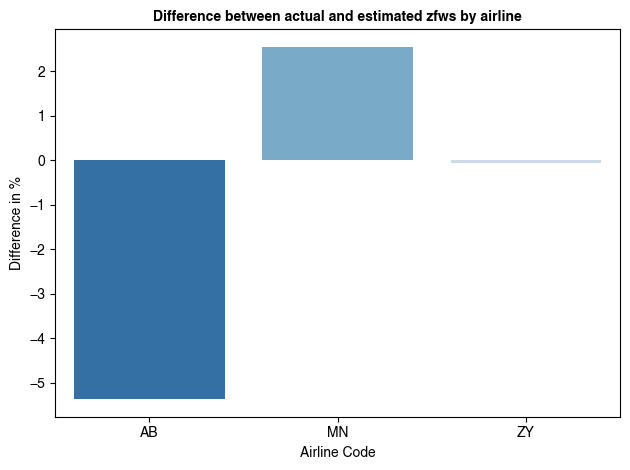

In [29]:
sns.barplot(zfws_by_airline.reset_index(), x='airline_code', y='difference', palette="Blues_r", hue='airline_code')
plt.title("Difference between actual and estimated zfws by airline", fontproperties=bold_font)
plt.xticks(fontproperties=normal_font)
plt.yticks(fontproperties=normal_font)
plt.xlabel("Airline Code", fontproperties=normal_font)
plt.ylabel("Difference in %", fontproperties=normal_font)
plt.tight_layout()

plt.savefig(f"{VISUALIZATION_PATH}difference_between_actual_and_estimated_zfws_by_airline.svg")
plt.show()